In [1]:
from pandas import DataFrame
from MyModule import load_data

train_data = load_data("data/train_raw_final.txt")
val_data = load_data("data/val_raw_final.txt")
test_data = load_data("data/test_raw_final.txt")

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer


class WeiboDataset(Dataset):
    def __init__(self, data: DataFrame, tokenizer, max_len=128):
        self.texts = data["text"]
        self.labels = data["label"]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_len, 
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0), 
            'attention_mask': encoding["attention_mask"].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }



tokenizer = BertTokenizer.from_pretrained("./models/chinese-macbert-base")

max_len = 64
train_dataset = WeiboDataset(train_data, tokenizer, max_len)
val_dataset = WeiboDataset(val_data, tokenizer, max_len)
test_dataset = WeiboDataset(test_data, tokenizer, max_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [3]:
from transformers import BertModel
import torch.nn as nn

class BERT(nn.Module):
    def __init__(self, model_name, num_class=3) -> None:
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_class)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        out = self.fc(self.dropout(cls_output))
        return out

In [4]:
from tqdm.auto import tqdm

# from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT("./models/chinese-macbert-base").to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
num_epochs = 5

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

scaler = GradScaler('cuda')
accum_steps = 2

In [5]:
# 预训练语言模型的通用训练验证与测试函数
import copy
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

from MyModule import (
    plot_confusion_matrix, 
    plot_training_curves, 
    print_training_summary, 
    save_training_results, 
)

def train_bert_model_with_validation(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler=None,
    criterion=nn.CrossEntropyLoss(), 
    num_epochs=5, 
    device=torch.device('cuda'), 
    target_names=['Negative', 'Neutral', 'Positive'],
    patience=3,
    min_delta=0.001,
    use_amp=True,
    accum_steps=1,
    max_grad_norm=1.0
):
    """
    BERT模型训练函数，支持验证集评估和早停机制
    
    Args:
        model: BERT模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        optimizer: 优化器
        scheduler: 学习率调度器 (可选)
        criterion: 损失函数
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        patience: 早停耐心值，验证损失不下降的最大轮数
        min_delta: 最小改善阈值
        use_amp: 是否使用混合精度训练
        accum_steps: 梯度累积步数
        max_grad_norm: 梯度裁剪最大范数
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    # 早停相关变量
    if patience is not None and val_loader is not None:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    
    # 混合精度训练
    if use_amp:
        scaler = GradScaler('cuda')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for step, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, targets) / accum_steps
                
                scaler.scale(loss).backward()
                
                if (step + 1) % accum_steps == 0 or (step + 1) == len(train_loader):
                    if max_grad_norm > 0:
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    scaler.step(optimizer)
                    scaler.update()
                    if scheduler is not None:
                        scheduler.step()
                    optimizer.zero_grad()
            else:
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets) / accum_steps
                
                loss.backward()
                
                if (step + 1) % accum_steps == 0 or (step + 1) == len(train_loader):
                    if max_grad_norm > 0:
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    optimizer.zero_grad()
            
            total_train_loss += loss.item() * accum_steps
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_bert_model(model, val_loader, criterion, device, use_amp)
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            
            # 早停检查
            if patience is not None:
                current_val_loss = val_metrics['loss']
                if current_val_loss < best_val_loss - min_delta:
                    best_val_loss = current_val_loss
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    print(f"    ✓ New best validation loss: {best_val_loss:.4f}")
                else:
                    patience_counter += 1
                    print(f"    No improvement. Patience: {patience_counter}/{patience}")
                    
                if patience_counter >= patience:
                    print(f"    Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
                    model.load_state_dict(best_model_state)
                    break
            
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    # 添加早停信息到历史记录
    if patience is not None and val_loader is not None:
        history['early_stopped'] = patience_counter >= patience
        history['best_val_loss'] = best_val_loss
        history['stopped_epoch'] = epoch + 1 if patience_counter >= patience else num_epochs
    
    return history

def evaluate_bert_model(
    model, 
    data_loader, 
    criterion=nn.CrossEntropyLoss(), 
    device=torch.device('cuda'),
    use_amp=True
):
    """
    BERT模型评估函数
    
    Args:
        model: BERT模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        use_amp: 是否使用混合精度
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, targets)
            else:
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets)
            
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

def test_bert_model_comprehensive(
    model, 
    model_name, 
    test_loader, 
    device=torch.device('cuda'), 
    target_names=['Negative', 'Neutral', 'Positive'],
    use_amp=True
):
    """
    全面的BERT模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: BERT模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        use_amp: 是否使用混合精度
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
            else:
                logits = model(input_ids, attention_mask)
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("BERT MODEL TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

In [6]:
from MyModule import class_weights

# 重新初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = BERT("./models/chinese-macbert-base").to(device)

# 计算类别权重
weights = class_weights(train_data)

# 设置训练参数
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.AdamW(bert.parameters(), lr=2e-5, weight_decay=1e-3)
num_epochs = 10

# 学习率调度器
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

In [7]:
# 使用通用训练函数
bert_history = train_bert_model_with_validation(
    model=bert,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive'],
    patience=3,          # 早停耐心值
    min_delta=0.001,     # 最小改善阈值
    use_amp=True,        # 使用混合精度训练
    accum_steps=2,       # 梯度累积步数
    max_grad_norm=1.0    # 梯度裁剪
)

Training Epoch 1:   0%|          | 1/8532 [00:00<1:19:06,  1.80it/s]e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Training Epoch 1: 100%|██████████| 8532/8532 [14:22<00:00,  9.89it/s]


Epoch 1/10
    Train Loss: 0.6609	Train Accuracy: 0.6880
    Valid Loss: 0.4824	Valid Accuracy: 0.7944
    Valid Precision: 0.7934	Valid Recall: 0.7944	Valid F1: 0.7904
    ✓ New best validation loss: 0.4824
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [14:21<00:00,  9.90it/s]


Epoch 2/10
    Train Loss: 0.4711	Train Accuracy: 0.7960
    Valid Loss: 0.4340	Valid Accuracy: 0.8126
    Valid Precision: 0.8120	Valid Recall: 0.8126	Valid F1: 0.8101
    ✓ New best validation loss: 0.4340
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [14:21<00:00,  9.90it/s]


Epoch 3/10
    Train Loss: 0.4232	Train Accuracy: 0.8175
    Valid Loss: 0.4200	Valid Accuracy: 0.8215
    Valid Precision: 0.8201	Valid Recall: 0.8215	Valid F1: 0.8203
    ✓ New best validation loss: 0.4200
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [14:21<00:00,  9.90it/s]


Epoch 4/10
    Train Loss: 0.3840	Train Accuracy: 0.8353
    Valid Loss: 0.4161	Valid Accuracy: 0.8266
    Valid Precision: 0.8247	Valid Recall: 0.8266	Valid F1: 0.8242
    ✓ New best validation loss: 0.4161
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [14:21<00:00,  9.91it/s]


Epoch 5/10
    Train Loss: 0.3533	Train Accuracy: 0.8496
    Valid Loss: 0.4170	Valid Accuracy: 0.8309
    Valid Precision: 0.8290	Valid Recall: 0.8309	Valid F1: 0.8291
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [14:26<00:00,  9.85it/s]


Epoch 6/10
    Train Loss: 0.3227	Train Accuracy: 0.8636
    Valid Loss: 0.4243	Valid Accuracy: 0.8292
    Valid Precision: 0.8280	Valid Recall: 0.8292	Valid F1: 0.8270
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8532/8532 [14:22<00:00,  9.89it/s]


Epoch 7/10
    Train Loss: 0.3060	Train Accuracy: 0.8717
    Valid Loss: 0.4272	Valid Accuracy: 0.8325
    Valid Precision: 0.8310	Valid Recall: 0.8325	Valid F1: 0.8308
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.4161


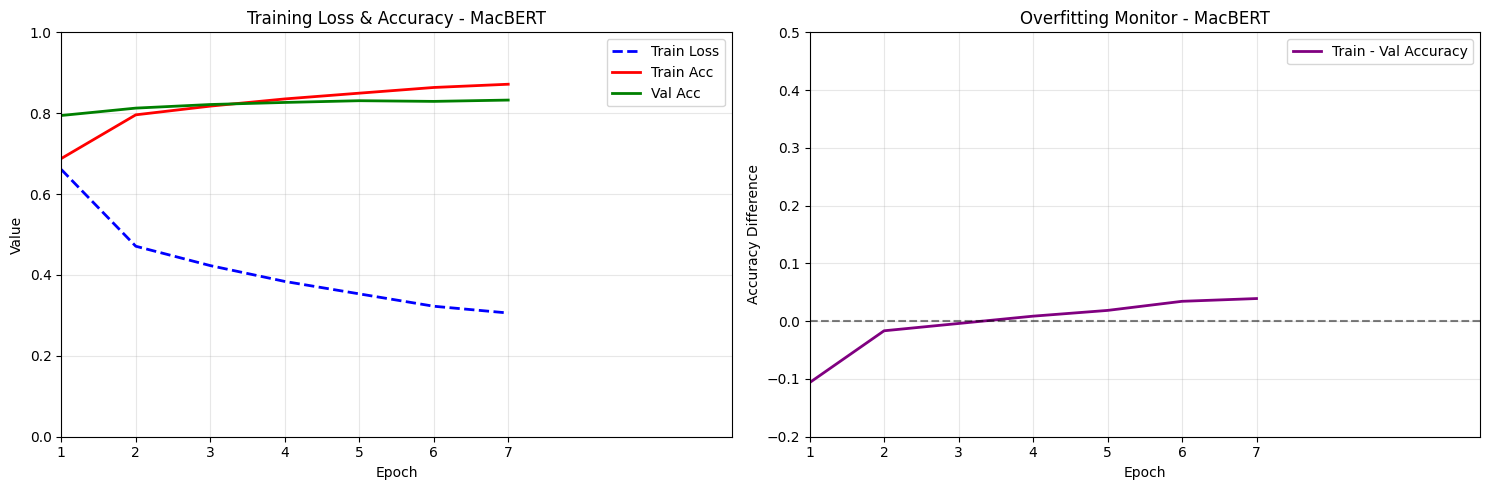


TRAINING SUMMARY
Model Name: MacBERT
Final Train Loss: 0.3060
Final Train Accuracy: 0.8717
Final Val Loss: 0.4272
Final Val Accuracy: 0.8325
Best Val Accuracy: 0.8325 (Epoch 7)
Final Overfitting Gap: 0.0392


In [8]:
# 绘制训练曲线
plot_training_curves("MacBERT", bert_history)

# 打印训练摘要
print_training_summary("MacBERT", bert_history)

Testing: 100%|██████████| 58497/58497 [07:54<00:00, 123.24it/s]



BERT MODEL TEST RESULTS
Model Name: MacBERT
Test Accuracy: 0.8266
Test Precision (weighted): 0.8245
Test Recall (weighted): 0.8266
Test F1 Score (weighted): 0.8243

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8528    0.8553    0.8540     18605
     Neutral     0.7704    0.6742    0.7191     14749
    Positive     0.8353    0.8946    0.8640     25143

    accuracy                         0.8266     58497
   macro avg     0.8195    0.8081    0.8124     58497
weighted avg     0.8245    0.8266    0.8243     58497



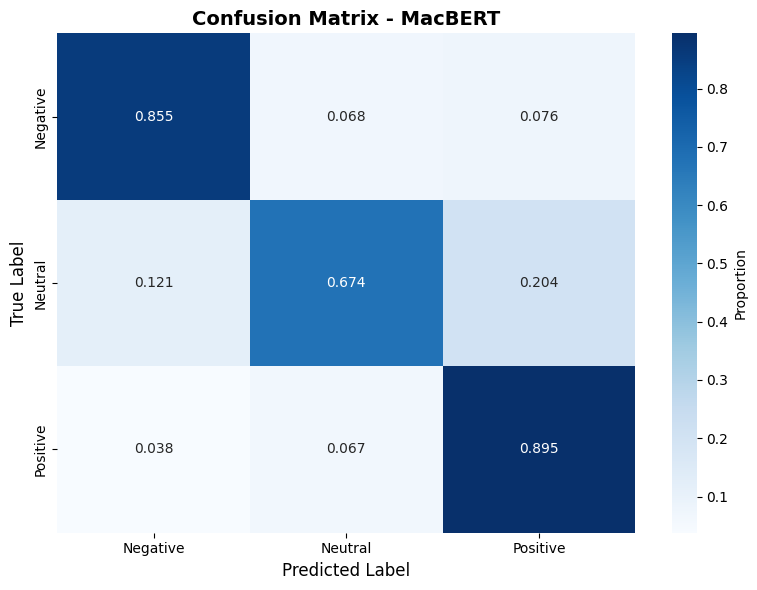


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8528, Recall=0.8553, F1=0.8540, Support=18605
 Neutral: Precision=0.7704, Recall=0.6742, F1=0.7191, Support=14749
Positive: Precision=0.8353, Recall=0.8946, F1=0.8640, Support=25143


In [9]:
# 进行全面测试
bert_test_results = test_bert_model_comprehensive(
    model=bert,
    model_name="MacBERT",
    test_loader=test_loader,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive'],
    use_amp=True
)


In [10]:
save_training_results(
    model=bert, 
    model_name="MacBERT", 
    set_epochs=num_epochs,
    actual_epochs=len(bert_history['train_losses']), 
    device=device, 
    use_pretrained_embeddings=False, 
    training_history=bert_history, 
    test_results=bert_test_results, 
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: MacBERT (BERT)
  - 实际训练轮数: 7
  - 测试准确率: 0.8266
  - 测试F1分数: 0.8243
  - 记录时间: 2025-11-17 15:26:40
  - 总记录数: 4
